Вам требуется сопоставить каждому изображению 6 наиболее похожих на него изображений из доступных. Задача с контеста Яндекс.

https://disk.yandex.ru/d/Hu-um0ASI6eAUg - ссылка на датасет. Датасет принадлежит компании Яндекс и используется исключительно в учебных целях.

In [49]:
import os
from PIL import Image
from torchvision import transforms

# needed input dimensions for the CNN
#inputDim = (256,256)
inputDir = "dataset"
inputDirCNN = "inputImagesCNN"

os.makedirs(inputDirCNN, exist_ok = True)

#transformationForCNNInput = transforms.Compose([transforms.Resize(inputDim)])

for imageName in os.listdir(inputDir):
    I = Image.open(os.path.join(inputDir, imageName))
    #newI = transformationForCNNInput(I)
    I.convert('RGB').save(os.path.join(inputDirCNN, imageName[0:-4] + ".jpg"))
    # copy the rotation information metadata from original image and save, else your transformed images may be rotated
    #exif = I.info['exif']
    #rgb_I.save(os.path.join(inputDirCNN, imageName))#, exif=exif#)
    
    I.close()
    #rgb_I.close()

In [50]:
import torch
from tqdm import tqdm
from torchvision import models


class Img2VecResnet18():
    def __init__(self):
        
        self.device = torch.device("cpu")
        self.numberFeatures = 512
        self.modelName = "resnet-18"
        self.model, self.featureLayer = self.getFeatureLayer()
        self.model = self.model.to(self.device)
        self.model.eval()
        self.toTensor = transforms.ToTensor()
        
        # normalize the resized images as expected by resnet18
        # [0.485, 0.456, 0.406] --> normalized mean value of ImageNet, [0.229, 0.224, 0.225] std of ImageNet
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
    def getVec(self, img):
        image = self.normalize(self.toTensor(img)).unsqueeze(0).to(self.device)
        embedding = torch.zeros(1, self.numberFeatures, 1, 1)

        def copyData(m, i, o): embedding.copy_(o.data)

        h = self.featureLayer.register_forward_hook(copyData)
        self.model(image)
        h.remove()

        return embedding.numpy()[0, :, 0, 0]

    def getFeatureLayer(self):
        
        cnnModel = models.resnet18(pretrained=True)
        layer = cnnModel._modules.get('avgpool')
        self.layer_output_size = 512
        
        return cnnModel, layer
        

# generate vectors for all the images in the set
img2vec = Img2VecResnet18() 

allVectors = {}
print("Converting images to feature vectors:")
for image in tqdm(os.listdir("inputImagesCNN")):
    I = Image.open(os.path.join("inputImagesCNN", image))
    vec = img2vec.getVec(I)
    allVectors[image] = vec
    I.close() 

C:\Users\mylti\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mylti\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Converting images to feature vectors:


100%|██████████████████████████████████████████████████████████████████████████████| 9605/9605 [32:53<00:00,  4.87it/s]


In [51]:
# now let us define a function that calculates the cosine similarity entries in the similarity matrix
import pandas as pd
import numpy as np

def getSimilarityMatrix(vectors):
    v = np.array(list(vectors.values())).T
    sim = np.inner(v.T, v.T) / ((np.linalg.norm(v, axis=0).reshape(-1,1)) * ((np.linalg.norm(v, axis=0).reshape(-1,1)).T))
    keys = list(vectors.keys())
    matrix = pd.DataFrame(sim, columns = keys, index = keys)
    
    return matrix
        
similarityMatrix = getSimilarityMatrix(allVectors)

In [54]:
from numpy.testing import assert_almost_equal
import pickle

k = 7 # the number of top similar images to be stored

similarNames = pd.DataFrame(index = similarityMatrix.index, columns = range(k))
similarValues = pd.DataFrame(index = similarityMatrix.index, columns = range(k))

for j in tqdm(range(similarityMatrix.shape[0])):
    kSimilar = similarityMatrix.iloc[j, :].sort_values(ascending = False).head(k)
    similarNames.iloc[j, :] = list(kSimilar.index)
    similarValues.iloc[j, :] = kSimilar.values
    
similarNames.to_pickle("similarNames.pkl")
similarValues.to_pickle("similarValues.pkl")

100%|█████████████████████████████████████████████████████████████████████████████| 9605/9605 [00:15<00:00, 618.01it/s]


In [55]:
similarNames

,0,1,2,3,4,5,6
0000.jpg,0000.jpg,2023.jpg,7054.jpg,9405.jpg,8222.jpg,6014.jpg,7235.jpg
0001.jpg,0001.jpg,1995.jpg,5193.jpg,2575.jpg,3853.jpg,7459.jpg,5029.jpg
0002.jpg,0002.jpg,7688.jpg,3977.jpg,2448.jpg,5492.jpg,1858.jpg,8914.jpg
0003.jpg,0003.jpg,6326.jpg,0174.jpg,4885.jpg,1239.jpg,0024.jpg,7875.jpg
0004.jpg,0004.jpg,6371.jpg,4593.jpg,6985.jpg,9406.jpg,2455.jpg,3507.jpg
...,...,...,...,...,...,...,...
9600.jpg,9600.jpg,3100.jpg,6353.jpg,0095.jpg,9167.jpg,2891.jpg,6074.jpg
9601.jpg,9601.jpg,4463.jpg,0789.jpg,5808.jpg,7463.jpg,8995.jpg,8581.jpg
9602.jpg,9602.jpg,5715.jpg,0760.jpg,2473.jpg,4798.jpg,5991.jpg,8635.jpg
9603.jpg,9603.jpg,8022.jpg,9449.jpg,6401.jpg,1286.jpg,7483.jpg,8816.jpg


In [56]:
similarValues

,0,1,2,3,4,5,6
0000.jpg,1.0,0.854687,0.852729,0.851979,0.841979,0.835779,0.835769
0001.jpg,1.0,0.850713,0.831949,0.818096,0.811386,0.80974,0.805662
0002.jpg,1.0,0.878607,0.844208,0.835733,0.81585,0.801147,0.788007
0003.jpg,1.0,0.757691,0.74999,0.742749,0.726822,0.722684,0.720707
0004.jpg,1.0,0.91151,0.800355,0.791498,0.771639,0.766917,0.764922
...,...,...,...,...,...,...,...
9600.jpg,1.0,0.810231,0.784776,0.779026,0.770546,0.755875,0.755117
9601.jpg,1.0,0.844855,0.835195,0.823547,0.813638,0.813444,0.812497
9602.jpg,1.0,0.83778,0.824939,0.805742,0.803123,0.791369,0.789575
9603.jpg,1.0,0.846092,0.837089,0.822264,0.805786,0.802043,0.800862


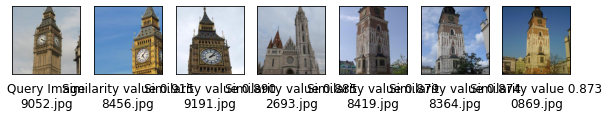

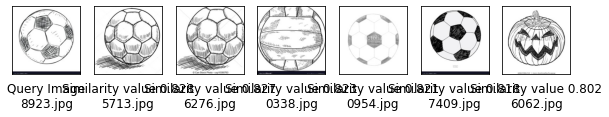

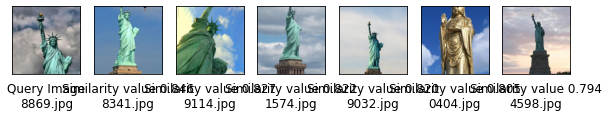

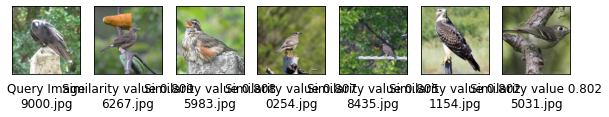

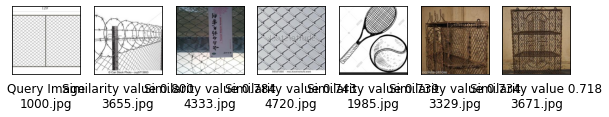

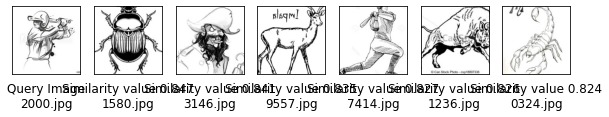

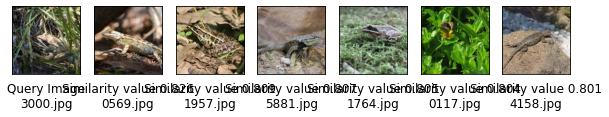

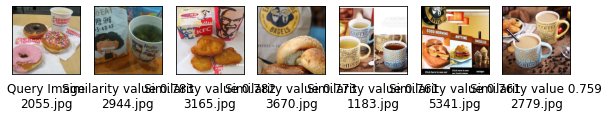

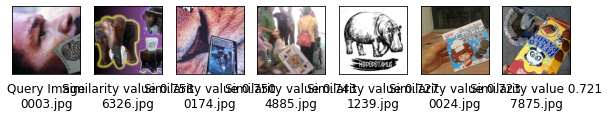

In [68]:
import matplotlib.pyplot as plt
    
# take three examples from the provided image set and plot
inputImages = ["9052.jpg", '8923.jpg', '8869.jpg', '9000.jpg', '1000.jpg', '2000.jpg', '3000.jpg', '2055.jpg', '0003.jpg']

numCol = 7
numRow = 1

def setAxes(ax, image, query = False, **kwargs):
    value = kwargs.get("value", None)
    if query:
        ax.set_xlabel("Query Image\n{0}".format(image), fontsize = 12)
    else:
        ax.set_xlabel("Similarity value {1:1.3f}\n{0}".format( image,  value), fontsize = 12)
    ax.set_xticks([])
    ax.set_yticks([])
    
def getSimilarImages(image, simNames, simVals):
    if image in set(simNames.index):
        imgs = list(simNames.loc[image, :])
        vals = list(simVals.loc[image, :])
        if image in imgs:
            assert_almost_equal(max(vals), 1, decimal = 5)
            imgs.remove(image)
            vals.remove(max(vals))
        return imgs, vals
    else:
        print("'{}' Unknown image".format(image))
        
def plotSimilarImages(image, simiarNames, similarValues):
    simImages, simValues = getSimilarImages(image, similarNames, similarValues)
    fig = plt.figure(figsize=(10, 20))
    
    # now plot the  most simliar images
    for j in range(0, numCol*numRow):
        ax = []
        if j == 0:
            img = Image.open(os.path.join(inputDirCNN, image))
            ax = fig.add_subplot(numRow, numCol, 1)
            setAxes(ax, image, query = True)
        else:
            img = Image.open(os.path.join(inputDirCNN, simImages[j-1]))
            ax.append(fig.add_subplot(numRow, numCol, j+1))
            setAxes(ax[-1], simImages[j-1], value = simValues[j-1])
        img = img.convert('RGB')
        plt.imshow(img)
        img.close()
    
    plt.show()
        
for image in inputImages:
    plotSimilarImages(image, similarNames, similarValues)